# Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
import seaborn as sns
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage import exposure
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4,DenseNet121,ResNet50,MobileNetV3Small
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import warnings
warnings.filterwarnings('ignore')

2024-04-29 14:24:02.134908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 14:24:02.134968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 14:24:02.136404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading the Data

In [8]:
dir_names = ["No_DR", "Mild", "Moderate", "Proliferate_DR", "Severe"]
images=[]
labels=[]

In [9]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images')

In [10]:
for i, dir_name in enumerate(dir_names):
    if i==4:
        i=3
    os.chdir('./'+dir_name)
    imgs_names=os.listdir()
    for img_name in imgs_names:
        with Image.open(img_name) as image:
            image=np.array(image)
            images.append(image)
            labels.append(i)
    os.chdir('../')

<Axes: ylabel='count'>

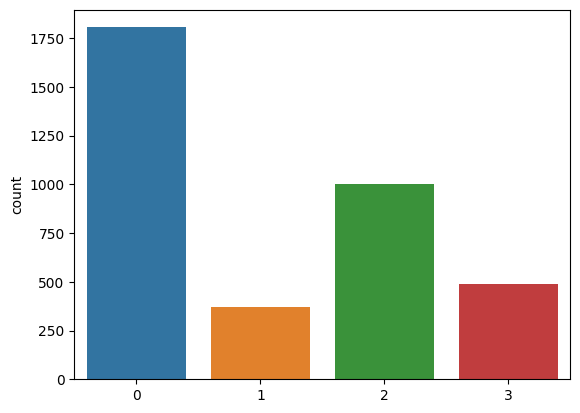

In [11]:
sns.countplot(x=labels)

In [12]:
(np.array(labels)==3).sum()

488

In [13]:
os.chdir('/kaggle/input/diabetic-retinopathy-resized-arranged')

# Combining two Datasets

In [14]:
max_images_per_label = 500
for i, _ in enumerate(dir_names):
    if i==4:
        i=3
    os.chdir('./'+f'{i}')
    imgs_names = os.listdir()
    count = labels.count(dir_names)
    for img_name in imgs_names:
        if count < max_images_per_label:
            with Image.open(img_name) as image:
                image = np.array(image)
                images.append(image)
                labels.append(i)
                count += 1
    os.chdir('../')

<Axes: ylabel='count'>

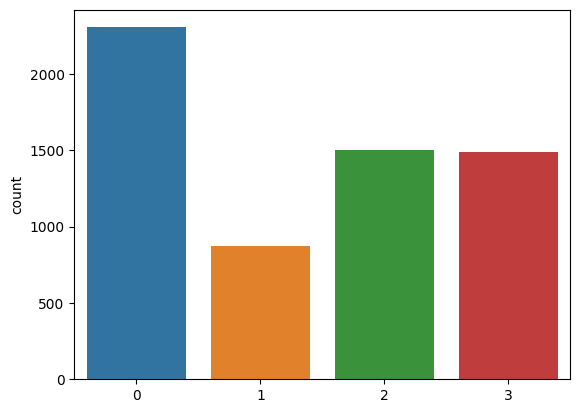

In [15]:
sns.countplot(x=labels)

In [16]:
(np.array(labels)==1).sum()

870

# Balancing Data

In [17]:
threshold_per_class = 800
filtered_images = []
filtered_labels = []
class_counts = {label: 0 for label in set(labels)}
for image, label in zip(images, labels):
    if class_counts[label] < threshold_per_class:
        filtered_images.append(image)
        filtered_labels.append(label)
        class_counts[label] += 1

<Axes: ylabel='count'>

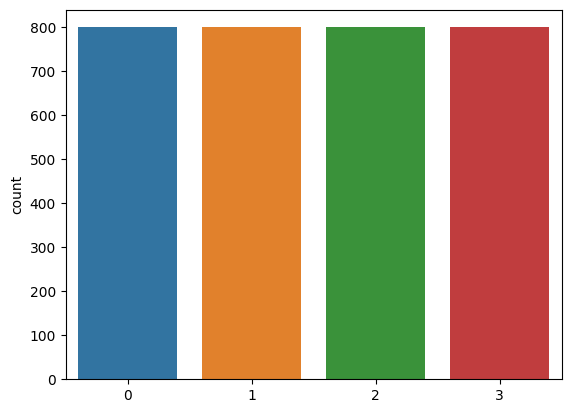

In [18]:
sns.countplot(x=filtered_labels)

In [19]:
len(filtered_images),len(filtered_labels)

(3200, 3200)

# Pre-Processing

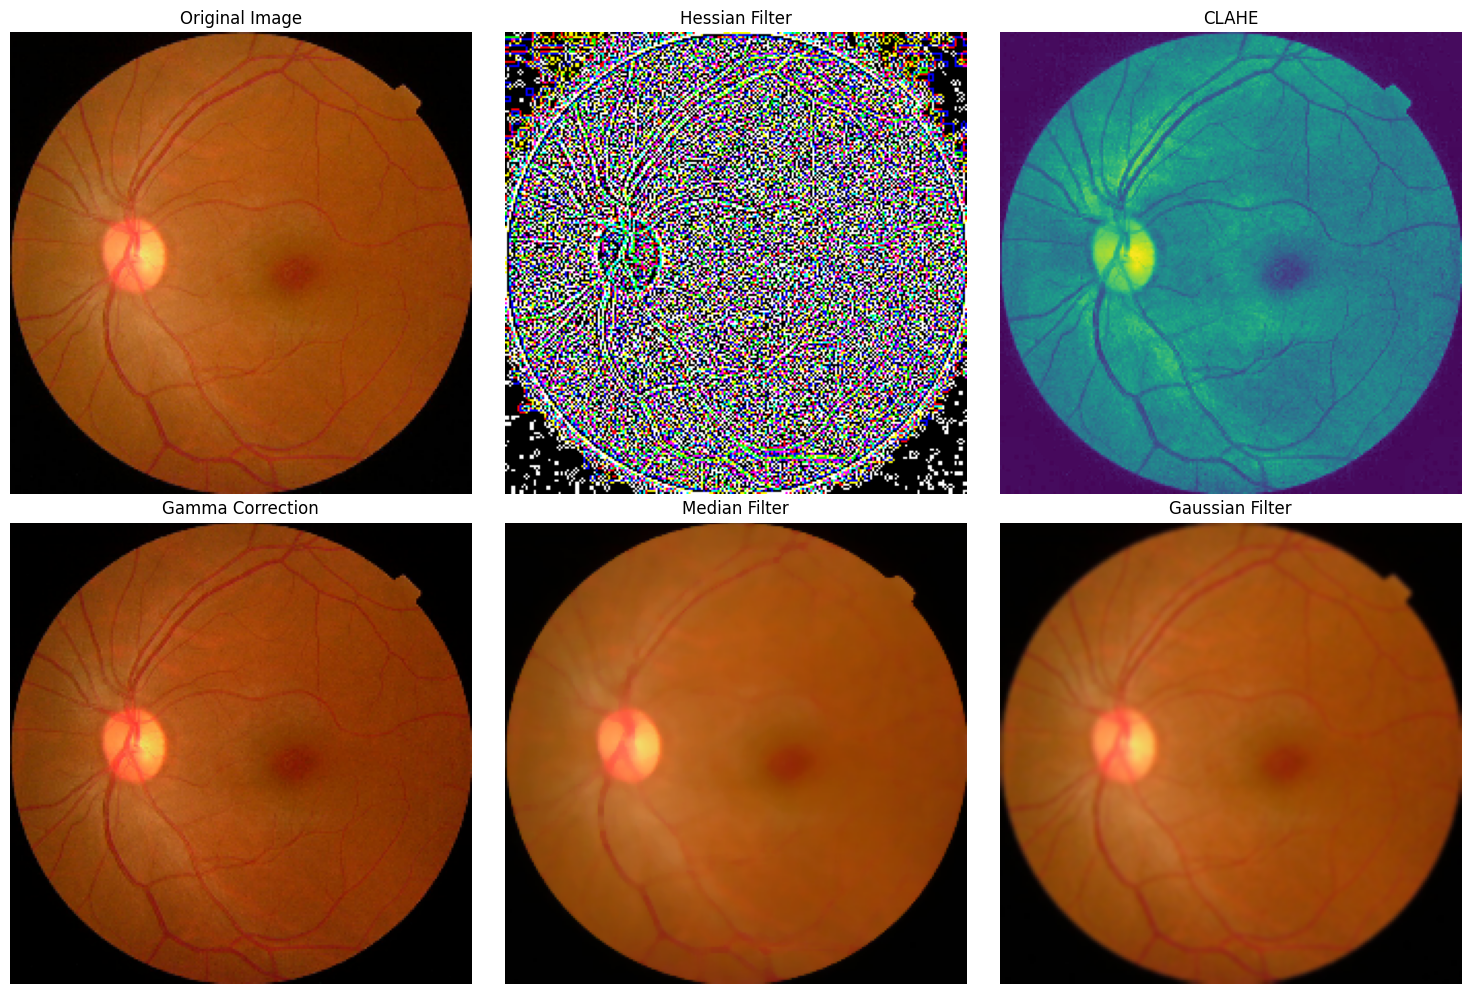

In [20]:
img_rgb=filtered_images[260]
processing_techniques = [
    ('Original Image', img_rgb),
    ('Hessian Filter', cv2.Laplacian(img_rgb, cv2.CV_64F)),
    ('CLAHE', cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)).apply(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))),
    ('Gamma Correction', exposure.adjust_gamma(img_rgb, gamma=1.2)),
    ('Median Filter', cv2.medianBlur(img_rgb, 5)),  # Applying Median filter with kernel size 5x5
    ('Gaussian Filter', cv2.GaussianBlur(img_rgb, (5, 5), 0))  # Applying Gaussian filter with kernel size 5x5
]
plt.figure(figsize=(15, 10))
for i, (title, processed_image) in enumerate(processing_techniques, start=1):
    plt.subplot(2, 3, i)
    plt.imshow(processed_image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l)
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    processed_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return processed_image

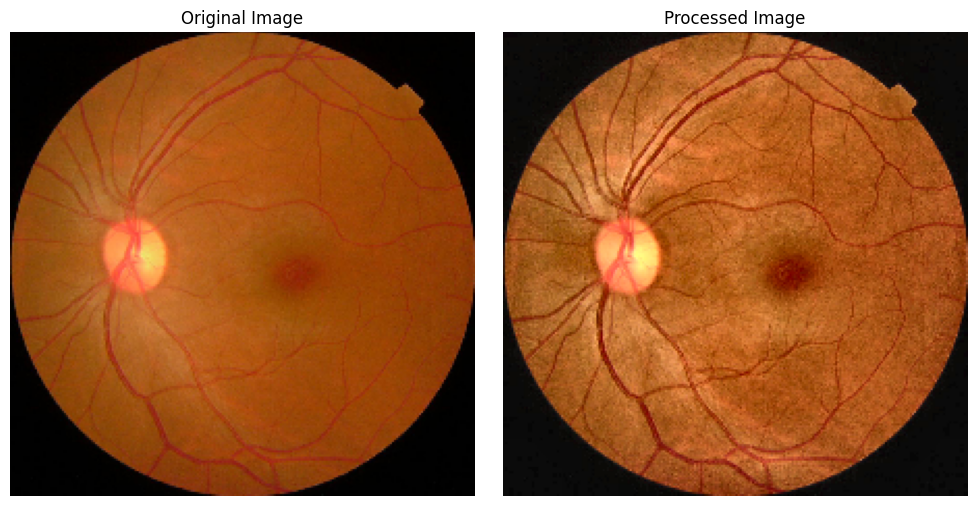

In [22]:
image_to_process = [(img_rgb, 'Original Image'), (preprocess_image(img_rgb), 'Processed Image')]
plt.figure(figsize=(10, 5))
for i, (image, title) in enumerate(image_to_process, start=1):
    plt.subplot(1, 2, i)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
preprocessed_images = [preprocess_image(img) for img in filtered_images]
preprocessed_images_resized = [Image.fromarray(img).resize((224, 224)) for img in preprocessed_images]
preprocessed_images_array = np.array([np.array(img) for img in preprocessed_images_resized])

In [24]:
filtered_labels = np.array(filtered_labels)
shuffled_indices = np.random.permutation(len(filtered_labels))
shuffled_preprocessed_images = preprocessed_images_array[shuffled_indices]
shuffled_filtered_labels = filtered_labels[shuffled_indices]

# Data Augmentation

In [25]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(rotate=(-10, 10)), 
    iaa.Affine(scale=(0.8, 1.2)) 
])

In [26]:
augmented_images = []
augmented_labels = []

In [27]:
for image, label in zip(shuffled_preprocessed_images, shuffled_filtered_labels):
    augmented_image = seq(image=image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [28]:
len(augmented_labels)

3200

In [29]:
final_images = np.concatenate((shuffled_preprocessed_images, augmented_images), axis=0)
final_labels = np.concatenate((shuffled_filtered_labels, augmented_labels), axis=0)
shuffled_indices = np.random.permutation(len(final_labels))
final_images = final_images[shuffled_indices]
final_labels = final_labels[shuffled_indices]

In [30]:
len(final_images)

6400

<Axes: ylabel='count'>

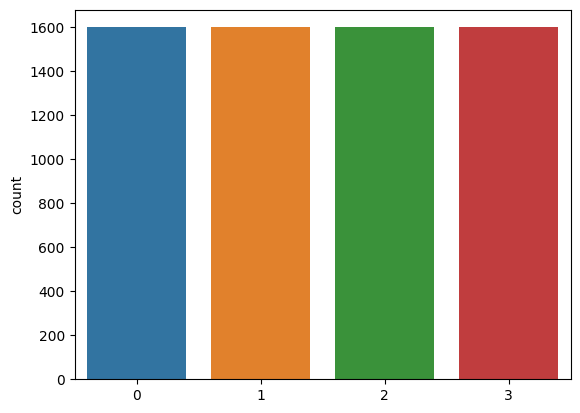

In [31]:
sns.countplot(x=final_labels)

In [32]:
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title('Label: ' + f'{labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

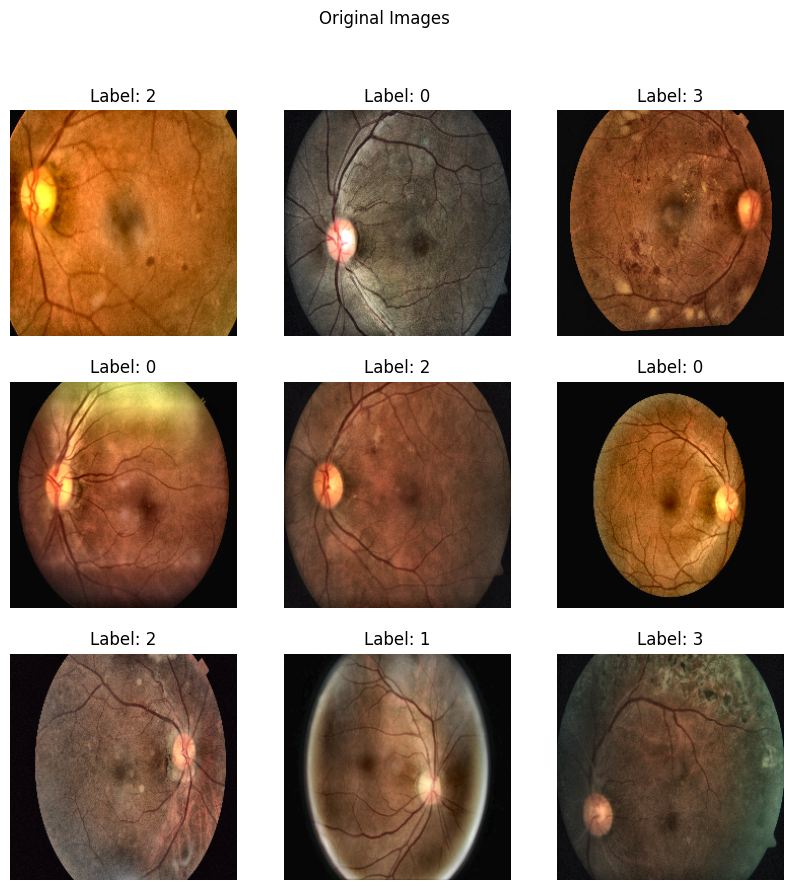

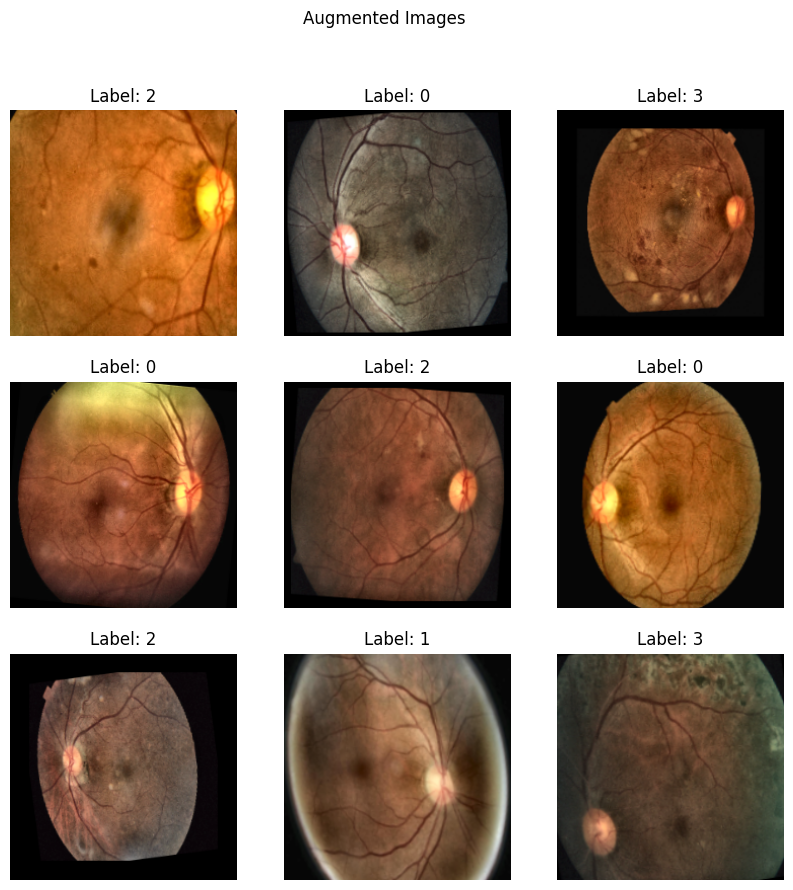

In [33]:
plot_images(shuffled_preprocessed_images[:9],shuffled_filtered_labels[:9], title='Original Images')
plot_images(augmented_images[:9], augmented_labels[:9], title='Augmented Images')

# Splitting the Data

In [34]:
x_train,x_test,y_train,y_test=train_test_split(final_images,final_labels,test_size=.2,stratify=final_labels,random_state=404)

# Transfer Learning Models

In [65]:
def build_model(pre_trained):
    x = pre_trained.output
    x = layers.Flatten()(x)  
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=pre_trained.input, outputs=predictions)    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# EfficientNetB4

In [30]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
model=build_model(base_model)

In [70]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

In [33]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=128)

Epoch 1/50


I0000 00:00:1714392835.047878     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714392835.159268     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.2968 - loss: 2.7743

W0000 00:00:1714392855.226323     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 116s 581ms/step - accuracy: 0.2974 - loss: 2.7761 - val_accuracy: 0.4516 - val_loss: 2.5930 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.3900 - loss: 2.7162 - val_accuracy: 0.5219 - val_loss: 2.2238 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.4271 - loss: 2.3981 - val_accuracy: 0.5813 - val_loss: 1.9143 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.4829 - loss: 2.1318 - val_accuracy: 0.6289 - val_loss: 1.6961 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - accuracy: 0.4974 - loss: 1.8952 - val_accuracy: 0.6523 - val_loss: 1.5066 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - accuracy: 0.5226 - loss: 1.7361 - val_accuracy: 0.6852 - val_loss: 1.4275 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.5647 - loss: 1.5887 - val

In [34]:
models=['EfficientNetB4','DenseNet','ResNet','VGG16']
accuracies=[]
cms=[]
histories=[]
trained_models=[]

In [35]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.8017 - loss: 0.7982


In [38]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# DenseNet 121

In [39]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [40]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 79ms/step - accuracy: 0.2989 - loss: 2.3511 - val_accuracy: 0.5094 - val_loss: 1.6768 - learning_rate: 0.0010
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.4156 - loss: 1.8326 - val_accuracy: 0.5578 - val_loss: 1.4472 - learning_rate: 0.0010
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5101 - loss: 1.5684 - val_accuracy: 0.5891 - val_loss: 1.3381 - learning_rate: 0.0010
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5305 - loss: 1.4565 - val_accuracy: 0.6219 - val_loss: 1.2352 - learning_rate: 0.0010
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.5627 - loss: 1.3840 - val_accuracy: 0.6180 - val_loss: 1.2888 - learning_rate: 0.0010
Epoch 6/50
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5905 - loss: 1.3131
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5904 - lo

In [44]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7267 - loss: 0.8016


# ResNet 50

In [47]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [49]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.3245 - loss: 2.7414 - val_accuracy: 0.5422 - val_loss: 2.0549 - learning_rate: 0.0010
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4546 - loss: 2.1553 - val_accuracy: 0.6328 - val_loss: 1.5445 - learning_rate: 0.0010
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5462 - loss: 1.6829 - val_accuracy: 0.6289 - val_loss: 1.4451 - learning_rate: 0.0010
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5815 - loss: 1.5431 - val_accuracy: 0.6875 - val_loss: 1.2635 - learning_rate: 0.0010
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.6259 - loss: 1.3926 - val_accuracy: 0.7289 - val_loss: 1.1815 - learning_rate: 0.0010
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.6321 - loss: 1.3419 - val_accuracy: 0.7305 - val_loss: 1.1268 - learning_rate: 0.0010
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6702 - l

In [50]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8049 - loss: 0.6514


# MobileNetV3Small

In [71]:
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=build_model(base_model)

In [72]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=128)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.3279 - loss: 2.3263 - val_accuracy: 0.4828 - val_loss: 2.6253 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4456 - loss: 2.0013 - val_accuracy: 0.5391 - val_loss: 1.7972 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4805 - loss: 1.7995 - val_accuracy: 0.6086 - val_loss: 1.5410 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5562 - loss: 1.5963 - val_accuracy: 0.6617 - val_loss: 1.3505 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5751 - loss: 1.4785 - val_accuracy: 0.6875 - val_loss: 1.2488 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6075 - loss: 1.3821 - val_accuracy: 0.6938 - val_loss: 1.2082 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6209 - loss: 1.3247 - val_a

In [73]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7973 - loss: 0.9117


# Evaluating the Models

In [74]:
models_names=['EfficientNetB4','DenseNet 121','ResNet 50','MobileNetV3 Small']
data = {'Model': models_names, 'Accuracy': accuracies}
df = pd.DataFrame(data)
df.head()

Model  Accuracy
0     EfficientNetB4  0.810938
1       DenseNet 121  0.733594
2          ResNet 50  0.820312
3  MobileNetV3 Small  0.808594

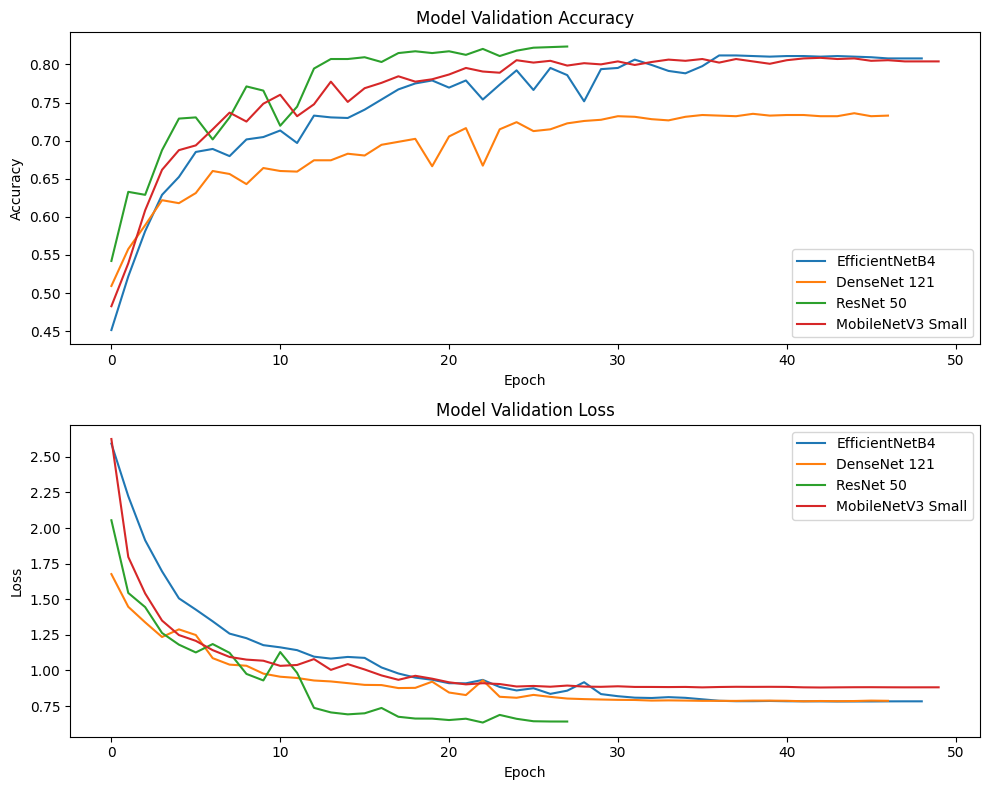

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for history, model_name in zip(histories, models_names):
    axs[0].plot(history.history['val_accuracy'], label=model_name)
    axs[0].set_title('Model Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[1].plot(history.history['val_loss'], label=model_name  )
    axs[1].set_title('Model Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

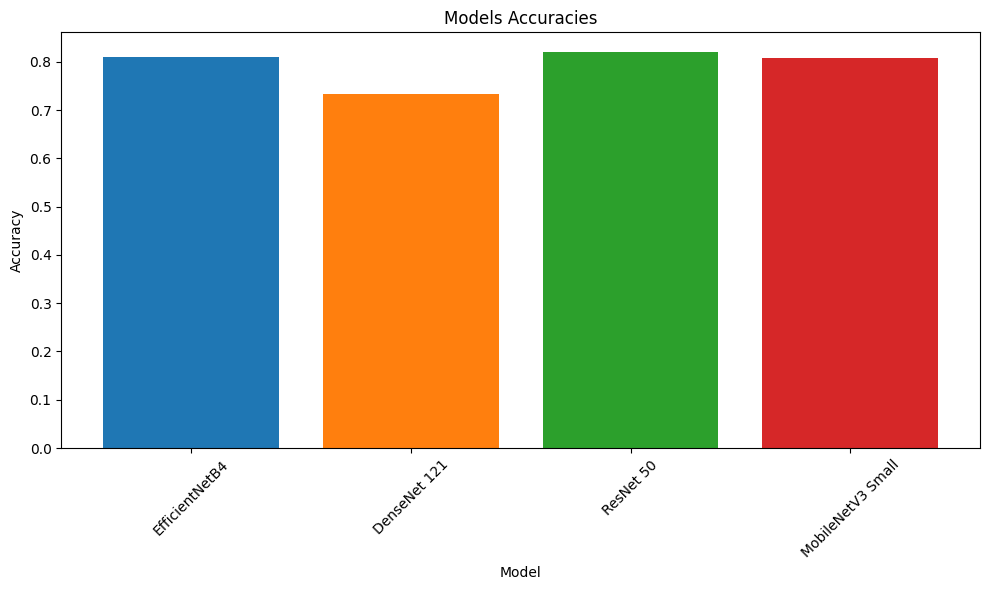

In [76]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Accuracy'], color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Models Accuracies')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

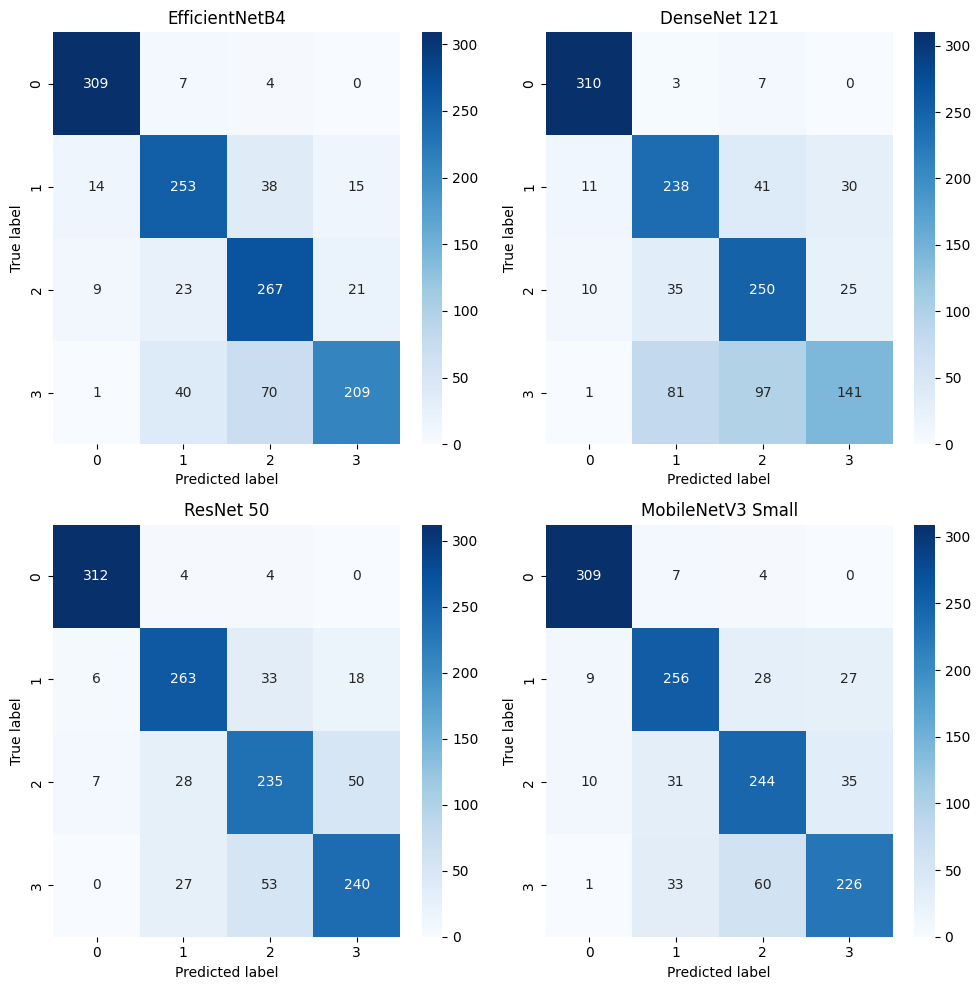

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax, cm, model_name in zip(axs.flatten(), cms, models_names):
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.tight_layout()
plt.show()

# Choosing the Best Model

In [78]:
predicted_probs = trained_models[2].predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
print(classification_report(y_test, y_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       320
           1       0.82      0.82      0.82       320
           2       0.72      0.73      0.73       320
           3       0.78      0.75      0.76       320

    accuracy                           0.82      1280
   macro avg       0.82      0.82      0.82      1280
weighted avg       0.82      0.82      0.82      1280



In [79]:
resnet=trained_models[2]

In [80]:
resnet.save('/kaggle/working/resnet4classes.h5')